In [19]:
%load_ext autoreload
%autoreload 2

home_or_office = "home"

import sys
if home_or_office =="home":
    sys.path.extend(['C:\\Code\\Libraries', 'C:/Code/Libraries'])
else:
    sys.path.extend(['C:\\Users\\troy\\Documents\\Code\\Libraries', 'C:\\Users\\troy\\Documents\\Excel Sheets', 
                     'C:/Users/troy/Documents/Code/Libraries'])
    
# From Scratch 
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import time 
from collections import namedtuple
from dataclasses import dataclass

from ItoSimulation.ItoSimulation.Stats import Gaussianize
from scipy.stats import gaussian_kde, norm, skew, kurtosis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Code\Libraries\ItoSimulation\ItoSimulation\Stats\distribution_api.py:25: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ItoSimulation.ItoSimulation.Stats.GOFTests import ad_test


ModuleNotFoundError: No module named 'autograd'

In [17]:
# Code 

class SimulatePaths:
    def __init__(self, num_paths, T):
        self.num_paths = num_paths
        self.T = T
        self.shocks = np.random.normal(0, 1, (num_paths, T))
        
    def simulate_randomdrift(self, drift_mean=0, drift_std=1):
        time_step = 1 / self.shocks.shape[1]
        self.drift = np.random.normal(drift_mean, drift_std, self.num_paths)
        sample_shocks = self.drift[:, None] * time_step + self.shocks * np.sqrt(time_step)
        sample_paths = np.hstack([np.zeros((self.num_paths, 1)), np.cumsum(sample_shocks, axis=1)])
        return sample_paths
    
    def simulate_bm(self):
        time_step = 1 / self.shocks.shape[1]
        sample_shocks = self.shocks * np.sqrt(time_step)
        sample_paths = np.hstack([np.zeros((self.num_paths, 1)), np.cumsum(sample_shocks, axis=1)])
        return sample_paths
    
    def simulate_ou(self, mean=0, speed=1, vol=1):
        time_step = 1 / self.shocks.shape[1]
        sample_shocks = self.shocks * np.sqrt(time_step)
        sample_paths = np.zeros((self.num_paths, self.T))
        sample_paths[:, 0] = mean
        for i in range(1, self.T):
            sample_paths[:, i] = sample_paths[:, i-1] + speed * (mean - sample_paths[:, i-1]) * time_step + vol * sample_shocks[:, i]
        return sample_paths
    
    def plot_paths(self, paths, alt_paths=None):
        T = paths.shape[1] - 1
        plt.subplot(2, 1, 1)
        plt.plot(paths.T, color='gray', alpha=0.1)
        plt.plot(paths.mean(axis=0), color="black", linestyle="--")
        plt.subplot(2, 1, 2)
        plt.plot(paths.std(axis=0), color='black')
        plt.plot(alt_paths.std(axis=0), color='red')
        plt.plot(np.sqrt(np.linspace(0, 1, T + 1) + np.linspace(0, 1, T + 1)**2), color='gray', linestyle="--")

exit_params = namedtuple('exit_params', ['dn_barrier', 'up_barrier', 'paths', 'running_max_dn_cross', 'running_min_up_cross', 'stopped_value', 'stopped_time', 'prob_crossing_up', 'prob_crossing_dn', 'prob_not_crossing', 'stopped_time_up_dist', 'stopped_time_dn_dist'])
population_stats = namedtuple('population_stats', ['mean', 'stdev', 'skew', 'kurtosis'])

class ExitTimes:
    def __init__(self, paths) -> None:
        self.paths = paths
        self.num_paths = paths.shape[0]
        self.T = paths.shape[1] - 1
        self.dt = 1 / self.T
        
        self.exit_params = exit_params(-np.inf, np.inf, None, None, None, None, None, None, None, None, None, None)
        self.kde_exit_up = None
        self.kde_exit_dn = None
        
        # TODO: Add running max and min KDE plot
        self.kde_running_max_dn = None
        self.kde_running_min_up = None
        
        self.exit_time_up_stats = population_stats(None, None, None, None)
        self.exit_time_dn_stats = population_stats(None, None, None, None)
        self.stopped_value_stats = population_stats(None, None, None, None)
        self.running_min_up_stats = population_stats(None, None, None, None)
        self.running_max_dn_stats = population_stats(None, None, None, None)
        
    def set_upbarrier(self, up_barrier):
        self.up_barrier = up_barrier
    
    def set_dnbarrier(self, dn_barrier):
        self.dn_barrier = dn_barrier
    
    def compute_exit_time_stats(self):
        t = time.time()
        paths = self.paths
        up_barrier = self.exit_params.up_barrier
        dn_barrier = self.exit_params.dn_barrier
        T = self.T 
        
        paths_clipped = ((paths > up_barrier)|(paths < dn_barrier))*1
        first_cross_indices = np.argmax(paths_clipped, axis=1)
        first_cross_indices[first_cross_indices==0] = T
        stopped_value = paths[np.arange(paths.shape[0]), first_cross_indices]
        first_cross_up_indices = first_cross_indices[stopped_value > up_barrier]
        first_cross_dn_indices = first_cross_indices[stopped_value < dn_barrier]
        num_time_stopped_up = len(first_cross_up_indices)
        num_time_stopped_dn = len(first_cross_dn_indices)
        prob_crossing_up = num_time_stopped_up / paths.shape[0]
        prob_crossin_dn = num_time_stopped_dn / paths.shape[0]
        prob_not_crossing = 1 - prob_crossing_up - prob_crossin_dn
        
        masked_indices = np.arange(paths.shape[1]) < first_cross_indices[:, None]
        max_values = np.max(np.where(masked_indices, paths, dn_barrier), axis=1)  # Use np.nan to ignore in max
        min_values = np.min(np.where(masked_indices, paths, up_barrier), axis=1)  # Use np.inf to ignore in minh)
        # Apply filtering based on stopped_value conditions directly
        running_max_dn_cross = max_values[stopped_value < dn_barrier]
        running_min_up_cross = min_values[stopped_value > up_barrier]
        
        return_dict =  {
            'dn_barrier': dn_barrier,
            'up_barrier': up_barrier,
            'paths': paths,
            'running_max_dn_cross': running_max_dn_cross, 
            'running_min_up_cross': running_min_up_cross,
            'stopped_value': stopped_value,
            'stopped_time': first_cross_indices / T,
            'prob_crossing_up': prob_crossing_up,
            'prob_crossing_dn': prob_crossin_dn, 
            'prob_not_crossing': prob_not_crossing,
            'stopped_time_up_dist': first_cross_up_indices,
            'stopped_time_dn_dist': first_cross_dn_indices
        }
        print("Total time: ", time.time() - t)
        self.exit_params = exit_params(**return_dict)
        self.exit_time_up_stats = population_stats(np.mean(first_cross_up_indices), np.std(first_cross_up_indices), skew(first_cross_up_indices), kurtosis(first_cross_up_indices))
        self.exit_time_dn_stats = population_stats(np.mean(first_cross_dn_indices), np.std(first_cross_dn_indices), skew(first_cross_dn_indices), kurtosis(first_cross_dn_indices))
        self.stopped_value_stats = population_stats(np.mean(stopped_value), np.std(stopped_value), skew(stopped_value), kurtosis(stopped_value))
        self.running_min_up_stats = population_stats(np.mean(running_min_up_cross), np.std(running_min_up_cross), skew(running_min_up_cross), kurtosis(running_min_up_cross))
        self.running_max_dn_stats = population_stats(np.mean(running_max_dn_cross), np.std(running_max_dn_cross), skew(running_max_dn_cross), kurtosis(running_max_dn_cross))
    
    def fit_kde_exit_time_dn(self):
        exit_params = self.exit_params
        Y = np.log(exit_params.stopped_time_dn_dist)
        sortX = np.sort(exit_params.stopped_time_dn_dist)
        usortX = np.unique(sortX)
        # plt.hist(Y / len(Y), bins=100, color='gray', alpha=0.5, density=True)
        gkde = gaussian_kde(np.sort(Y), bw_method='scott')
        self.kde_exit_up = lambda x: gkde(np.log(x)) / x
        
    def fit_kde_exit_time_up(self):
        exit_params = self.exit_params
        Y = np.log(exit_params.stopped_time_up_dist)
        sortX = np.sort(exit_params.stopped_time_up_dist)
        usortX = np.unique(sortX)
        # plt.hist(Y / len(Y), bins=100, color='gray', alpha=0.5, density=True)
        gkde = gaussian_kde(np.sort(Y), bw_method='scott')
        self.kde_exit_up = lambda x: gkde(np.log(x)) / x
        
    def fit_kde_running_max_dn(self):
        pass
    
    def fit_kde_running_min_up(self):
        pass
    
    def plot_stopped_value_and_time_dist(self):
        exit_params = self.exit_params
        
        plt.subplot(2, 1, 1)
        plt.hist(exit_params.stopped_value, bins=100, color='gray', alpha=0.5)
        plt.axvline(np.mean(exit_params.stopped_value), color='black', linestyle="--")    
        plt.axvline(np.mean(paths[:, -1]), color='red', linestyle="-")
        plt.title("Distribution of stopped values at boundary or final time")

        plt.subplot(2,1,2)
        plt.hist(exit_params.stopped_time, bins=100, color='gray', alpha=0.5)
        plt.axvline(np.mean(exit_params.stopped_time), color='black', linestyle="--")    
        plt.title("Distribution of stopped time at boundary or final time")

    def plot_exit_time_distribution(self):
        exit_params = self.exit_params
        plt.subplot(211)
        plt.hist(exit_params.stopped_time_up_dist, bins=100, color='gray', alpha=0.5)
        plt.axvline(np.mean(exit_params.stopped_time_up_dist), color='black', linestyle="--")  
        if self.kde_exit_up is not None:  
            sortX = np.sort(exit_params.stopped_time_up_dist)
            usortX = np.unique(sortX)
            plt.plot(usortX, self.kde_exit_up(usortX), color='red')
        plt.title("Distribution of stopped time at up barrier")
        
        plt.subplot(212)
        plt.hist(exit_params.stopped_time_dn_dist, bins=100, color='gray', alpha=0.5)
        plt.axvline(np.mean(exit_params.stopped_time_dn_dist), color='black', linestyle="--")    
        plt.title("Distribution of stopped time at down barrier")
    
    def plot_hist_running_max_min(self):
        exit_params = self.exit_params
        plt.hist(exit_params.running_max_dn_cross, bins=100, color='gray', alpha=0.5)
        plt.axvline(np.mean(exit_params.running_max_dn_cross), color='black', linestyle="--")    
        plt.title("Distribution of running max at down barrier")
        
        plt.hist(exit_params.running_min_up_cross, bins=100, color='gray', alpha=0.5)
        plt.axvline(np.mean(exit_params.running_min_up_cross), color='black', linestyle="--")    
        plt.title("Distribution of running min at up barrier")
    
    def plot_qq_stopped_value_vs_final(self):
        #Plot qq plot of stopped value vs final value
        exit_params = self.exit_params
        plt.subplot(2, 1, 1)
        plt.scatter(np.sort(exit_params.stopped_value), np.sort(exit_params.paths[:, -1]), color='gray', alpha=0.5)
        plt.plot([np.min(exit_params.stopped_value), np.max(exit_params.stopped_value)], [np.min(exit_params.stopped_value), np.max(exit_params.stopped_value)], color='black', linestyle="--")
        plt.title("QQ plot of stopped value vs final value")
    
    # reports
    
    def display_crossing_probabilities(self):
        exit_params = self.exit_params
        print("Prob of crossing up: ", exit_params.prob_crossing_up)
        print("Prob of crossing down: ", exit_params.prob_crossing_dn)
        print("Prob of not crossing: ", exit_params.prob_not_crossing)
    
    def display_stopped_value_stats(self):
        exit_params = self.exit_params
        print("Mean stopped value: ", np.mean(exit_params.stopped_value))
        print("Mean final value: ", np.mean(exit_params.paths[:, -1]))
        print("Stdev stopped value: ", np.std(exit_params.stopped_value))
        print("Stdev final value: ", np.std(exit_params.paths[:, -1]))
        print("skew stopped value: ", skew(exit_params.stopped_value))
        print("skew final value: ", skew(exit_params.paths[:, -1]))
        print("kurtosis stopped value: ", kurtosis(exit_params.stopped_value))
        print("kurtosis final value: ", kurtosis(exit_params.paths[:, -1]))
    
    def display_stopped_time_stats(self):
        exit_params = self.exit_params
        print("Mean stopped time: ", np.mean(exit_params.stopped_time))
        print("Stdev stopped time: ", np.std(exit_params.stopped_time))
        print("skew stopped time: ", skew(exit_params.stopped_time))
        print("kurtosis stopped time: ", kurtosis(exit_params.stopped_time))
        
    def display_running_max_min_stats(self):
        exit_params = self.exit_params
        print("Mean running max at down barrier: ", np.mean(exit_params.running_max_dn_cross))
        print("Stdev running max at down barrier: ", np.std(exit_params.running_max_dn_cross))
        print("skew running max at down barrier: ", skew(exit_params.running_max_dn_cross))
        print("kurtosis running max at down barrier: ", kurtosis(exit_params.running_max_dn_cross))
        print("Mean running min at up barrier: ", np.mean(exit_params.running_min_up_cross))
        print("Stdev running min at up barrier: ", np.std(exit_params.running_min_up_cross))
        print("skew running min at up barrier: ", skew(exit_params.running_min_up_cross))
        print("kurtosis running min at up barrier: ", kurtosis(exit_params.running_min_up_cross))
        
    

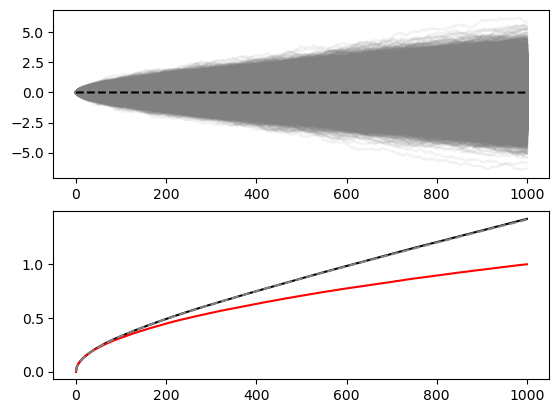

In [18]:
num_paths = 50000
T = 1000

objPaths = SimulatePaths(num_paths, T)
paths = objPaths.simulate_randomdrift()
bm_paths = objPaths.simulate_bm()

objPaths.plot_paths(paths, bm_paths)


In [15]:

dn_barrier = -0.1
up_barrier = -2 * dn_barrier


exit_params = namedtuple('exit_params', ['dn_barrier', 'up_barrier', 'paths', 'running_max_dn_cross', 'running_min_up_cross', 'stopped_value', 'stopped_time', 'prob_crossing_up', 'prob_crossing_dn', 'prob_not_crossing', 'stopped_time_up_dist', 'stopped_time_dn_dist'])

# Compute exits
def compute_exits_from_boundary2(paths, dn_barrier, up_barrier):
    t1 = t = time.time()
    # compute the running max and min
    running_max = np.maximum.accumulate(paths, axis=1)
    running_min = np.minimum.accumulate(paths, axis=1)
    print("time for computing running max and min: ", time.time() - t)
    t = time.time()
    # Compute the paths that crossed
    paths_clipped = ((paths > up_barrier)|(paths < dn_barrier))*1
    first_cross_indices = np.argmax(paths_clipped, axis=1)
    first_cross_indices = first_cross_indices[first_cross_indices > 0]
    print("time for computing stop time for each path: ", time.time() - t)
    t = time.time()
    
    stopped_value = paths[paths_crossed_idx, first_cross_time_step] # get the value at the first stop time
    # split by up and down cross
    up_crossed_idx = paths_crossed_idx[stopped_value > up_barrier]  # paths which stopped up
    down_crossed_idx = paths_crossed_idx[stopped_value < dn_barrier] # paths which stopped down
    
    # distribution of stopping time conditional on crossing up
    first_cross_time_step_up = first_cross_time_step[stopped_value > up_barrier]
    first_cross_time_step_dn = first_cross_time_step[stopped_value < dn_barrier]
    print("time for computing stopped_time conditional on up hit vs. down hit: ", time.time() - t)
    t = time.time()
    
    # Compute the paths that did not cross
    paths_not_crossed = np.array(list(set(np.arange(paths.shape[0])) - set(paths_crossed_idx)))  # Set(NotCrossed) = Set(All) - Set(Crossed)
    last_value = paths[paths_not_crossed, -1]

    # Compute the stopped values and time
    full_stopped_values = np.append(stopped_value, last_value)
    stopped_time = np.append(first_cross_time_step, np.ones(len(paths_not_crossed)) * paths.shape[1] - 1) # If not stopped, then time is the last time step
    print("time for computing full stopped values and stopped time: ", time.time() - t)
    t = time.time()
    
    # Probability of crossing up and down
    num_time_stopped_up = len(up_crossed_idx)
    num_time_stopped_dn = len(down_crossed_idx)
    
    # Compute vlaues of interest
    prob_crossing_up = num_time_stopped_up / paths.shape[0]
    prob_crossin_dn = num_time_stopped_dn / paths.shape[0]
    prob_not_crossing = 1 - prob_crossing_up - prob_crossin_dn
    print("time for computing up cross probability and dn cross probability: ", time.time() - t)
    t = time.time()
    
     # Running Maximum when paths cross the down barrier
    running_max_dn_cross = running_max[down_crossed_idx, first_cross_time_step_dn]
    
    
    # 2. Running Minimum when paths cross the up barrier
    running_min_up_cross = running_min[up_crossed_idx, first_cross_time_step[stopped_value > up_barrier]]
    print("time for computing max and min conditional on up and down cross: ", time.time() - t)
    
    print("Total time: ", time.time() - t1)

    return_dict =  {
        'dn_barrier': dn_barrier,
        'up_barrier': up_barrier,
        'paths': paths,
        'running_max_dn_cross': running_max_dn_cross, 
        'running_min_up_cross': running_min_up_cross,
        'stopped_value': full_stopped_values,
        'stopped_time': stopped_time,
        'prob_crossing_up': prob_crossing_up,
        'prob_crossin_dn': prob_crossin_dn, 
        'prob_not_crossing': prob_not_crossing,
        'stopped_time_up_dist': first_cross_time_step_up,
        'stopped_time_dn_dist': first_cross_time_step_dn
    }
    
    return exit_params(**return_dict)

def compute_exits_from_boundary(paths, dn_barrier, up_barrier):
    t = time.time()
    paths_clipped = ((paths > up_barrier)|(paths < dn_barrier))*1
    first_cross_indices = np.argmax(paths_clipped, axis=1)
    first_cross_indices[first_cross_indices==0] = T
    stopped_value = paths[np.arange(paths.shape[0]), first_cross_indices]
    first_cross_up_indices = first_cross_indices[stopped_value > up_barrier]
    first_cross_dn_indices = first_cross_indices[stopped_value < dn_barrier]
    num_time_stopped_up = len(first_cross_up_indices)
    num_time_stopped_dn = len(first_cross_dn_indices)
    prob_crossing_up = num_time_stopped_up / paths.shape[0]
    prob_crossin_dn = num_time_stopped_dn / paths.shape[0]
    prob_not_crossing = 1 - prob_crossing_up - prob_crossin_dn
    
    masked_indices = np.arange(paths.shape[1]) < first_cross_indices[:, None]
    max_values = np.max(np.where(masked_indices, paths, dn_barrier), axis=1)  # Use np.nan to ignore in max
    min_values = np.min(np.where(masked_indices, paths, up_barrier), axis=1)  # Use np.inf to ignore in minh)
    # Apply filtering based on stopped_value conditions directly
    running_max_dn_cross = max_values[stopped_value < dn_barrier]
    running_min_up_cross = min_values[stopped_value > up_barrier]
    
    return_dict =  {
        'dn_barrier': dn_barrier,
        'up_barrier': up_barrier,
        'paths': paths,
        'running_max_dn_cross': running_max_dn_cross, 
        'running_min_up_cross': running_min_up_cross,
        'stopped_value': stopped_value,
        'stopped_time': first_cross_indices / T,
        'prob_crossing_up': prob_crossing_up,
        'prob_crossing_dn': prob_crossin_dn, 
        'prob_not_crossing': prob_not_crossing,
        'stopped_time_up_dist': first_cross_up_indices,
        'stopped_time_dn_dist': first_cross_dn_indices
    }
    print("Total time: ", time.time() - t)
    return exit_params(**return_dict)

exit_params = compute_exits_from_boundary(bm_paths, dn_barrier, up_barrier)



NameError: name 'namedtuple' is not defined

In [6]:
exit_params.prob_crossing_up, exit_params.prob_crossing_dn, exit_params.prob_not_crossing, exit_params.dn_barrier / (exit_params.dn_barrier - exit_params.up_barrier)    

(0.3457, 0.6537, 0.0006000000000000449, 0.3333333333333333)

76.0
149.0


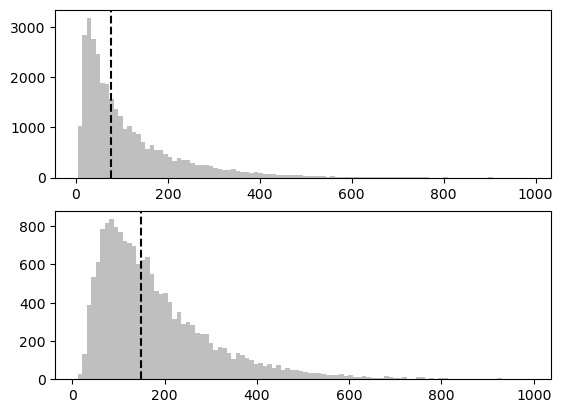

(array([3.18023356e-03, 8.73101877e-03, 9.79930633e-03, 8.46317722e-03,
        7.57037206e-03, 5.82170539e-03, 5.76321126e-03, 4.80575469e-03,
        4.22081338e-03, 3.78364671e-03, 3.00167253e-03, 3.18023356e-03,
        2.78308920e-03, 2.66610094e-03, 2.20122652e-03, 1.72711620e-03,
        2.01650821e-03, 1.70864436e-03, 1.71480164e-03, 1.43156690e-03,
        1.26839906e-03, 9.94400234e-04, 1.19451174e-03, 1.06828756e-03,
        1.05289437e-03, 9.17434271e-04, 7.94288732e-04, 7.88131455e-04,
        7.91210093e-04, 7.05008215e-04, 5.69548121e-04, 5.20289906e-04,
        4.80267605e-04, 4.74110328e-04, 5.04896713e-04, 4.15616197e-04,
        3.63279342e-04, 3.60200704e-04, 3.04785211e-04, 3.26335680e-04,
        2.95549295e-04, 2.49369718e-04, 2.00111502e-04, 2.49369718e-04,
        1.93954225e-04, 1.66246479e-04, 1.90875587e-04, 1.60089202e-04,
        1.38538732e-04, 1.50853286e-04, 1.20066901e-04, 1.01595070e-04,
        8.31232393e-05, 1.04673709e-04, 9.85164318e-05, 5.849413

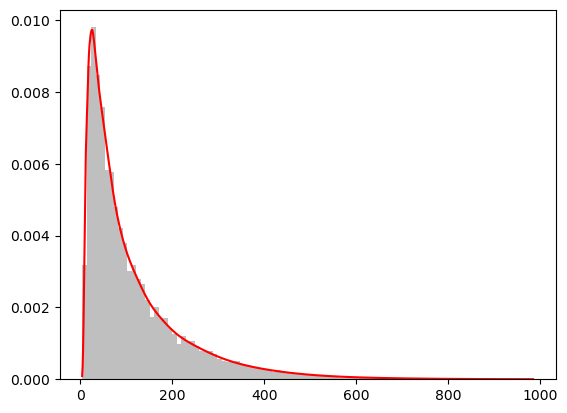

In [22]:


Y = np.log(exit_params.stopped_time_dn_dist)
sortX = np.sort(exit_params.stopped_time_dn_dist)
usortX = np.unique(sortX)
# plt.hist(Y / len(Y), bins=100, color='gray', alpha=0.5, density=True)
gkde = gaussian_kde(np.sort(Y), bw_method='scott')
plt.plot(usortX, gkde(np.log(usortX)) / usortX, color='red')
plt.hist(sortX, bins=100, color='gray', alpha=0.5, density=True)

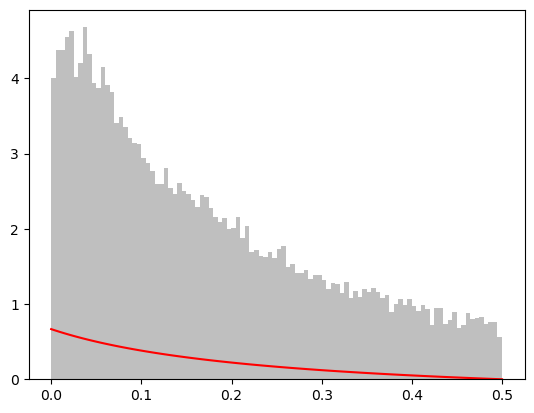

In [28]:
non_zero = exit_params.running_max_dn_cross[exit_params.running_max_dn_cross!=0]

plt.hist(exit_params.running_max_dn_cross[exit_params.running_max_dn_cross!=0], bins=100, color='gray', alpha=0.5, density=True)
plt.plot(np.linspace(0, 0.5, 100), (0.5 - np.linspace(0, 0.5, 100)) / 3 / (0.25 + np.linspace(0, 0.5, 100)), color='red')

In [14]:
import numpy as np

def num(k):
    s = 0
    if k > 1:
        digits = np.array([7] + [5]*(k-1) + [7]).astype(np.float32)
        num = np.sum([d*(10**i) for i, d in enumerate(digits)])
    else:
        num = 77
    return num

np.sum([num(i) for i in range(1, 100)]) - (num(100) - 77 + 100*13) / 9

0.0